In [1]:
!pip install scanpy pandas numpy matplotlib seaborn leidenalg
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

In [3]:
# Download and load the data
!wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE84nnn/GSE84133/suppl/GSE84133_RAW.tar
!tar -xvf GSE84133_RAW.tar

--2024-07-09 14:46:06--  https://ftp.ncbi.nlm.nih.gov/geo/series/GSE84nnn/GSE84133/suppl/GSE84133_RAW.tar
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.12, 130.14.250.13, 2607:f220:41e:250::11, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29122560 (28M) [application/x-tar]
Saving to: ‘GSE84133_RAW.tar.9’

GSE84133_RAW.tar.9  100%[===================>]  27.77M  76.1MB/s    in 0.4s    

2024-07-09 14:46:06 (76.1 MB/s) - ‘GSE84133_RAW.tar.9’ saved [29122560/29122560]

GSM2230757_human1_umifm_counts.csv.gz
GSM2230758_human2_umifm_counts.csv.gz
GSM2230759_human3_umifm_counts.csv.gz
GSM2230760_human4_umifm_counts.csv.gz
GSM2230761_mouse1_umifm_counts.csv.gz
GSM2230762_mouse2_umifm_counts.csv.gz


In [4]:
# Read the CSV file
df = pd.read_csv('GSM2230757_human1_umifm_counts.csv.gz')

# if matrix
# adata = sc.read_10x_mtx('GSM2230757_human1_umifm_counts/', var_names='gene_symbols', cache=True)

# If you need to convert it to an AnnData object
adata = sc.AnnData(df)

# Optionally, you can set the gene symbols as var_names
adata.var_names = df.columns

/usr/local/lib/python3.10/dist-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype object
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [5]:
adata

AnnData object with n_obs × n_vars = 1937 × 20128

In [6]:
print(df.dtypes)

Unnamed: 0          object
barcode             object
assigned_cluster    object
A1BG                 int64
A1CF                 int64
                     ...  
ZYG11B               int64
ZYX                  int64
ZZEF1                int64
ZZZ3                 int64
pk                   int64
Length: 20128, dtype: object


In [7]:
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [8]:
# Remove any rows or columns that are entirely NaN
df = df.dropna(how='all', axis=0)  # Drop rows that are all NaN
df = df.dropna(how='all', axis=1)  # Drop columns that are all NaN

In [9]:
adata = sc.AnnData(df)

/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [10]:
adata

AnnData object with n_obs × n_vars = 1937 × 20125

In [11]:
# Filter cells basically getting rid of cells fewer than 200 genes and genes that are found in fewer than 3 cells
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [12]:
adata

AnnData object with n_obs × n_vars = 1937 × 14738
    obs: 'n_genes'
    var: 'n_cells'

In [13]:
# # confirming the structure
# print(adata.var_names[:10])
# print(adata.var.index[:10])

# mito_genes = ['MT-ND1', 'MT-ND2', 'MT-ND3', 'MT-ND4', 'MT-ND4L', 'MT-ND5', 'MT-ND6',
#               'MT-CYB', 'MT-CO1', 'MT-CO2', 'MT-CO3', 'MT-ATP6', 'MT-ATP8',
#               'MT-RNR1', 'MT-RNR2', 'MT-TF', 'MT-TV', 'MT-TL1', 'MT-TI', 'MT-TQ',
#               'MT-TM', 'MT-TW', 'MT-TA', 'MT-TN', 'MT-TC', 'MT-TY', 'MT-TS1',
#               'MT-TD', 'MT-TK', 'MT-TG', 'MT-TR', 'MT-TH', 'MT-TS2', 'MT-TL2', 'MT-TE', 'MT-TT']

# adata.var['mt'] = adata.var_names.isin(mito_genes)

# sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)

# adata = adata[adata.obs.pct_counts_mt < 20]

# print(adata.var[adata.var.mt == True])

In [14]:
# Filter out cells with high mitochondrial content
adata.var['mt'] = adata.var_names.str.startswith('MT-')
adata.var['mt'] = adata.var_names.str.lower().str.startswith(('mt-', 'mt_', 'mtx'))

In [15]:
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"
ribo_genes = pd.read_table(ribo_url, skiprows=2, header = None)
ribo_genes

,0
0,FAU
1,MRPL13
2,RPL10
3,RPL10A
4,RPL10L
...,...
83,RPS9
84,RPSA
85,RSL24D1
86,RSL24D1P11


In [16]:
adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)

In [17]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], inplace=True)
adata = adata[adata.obs.pct_counts_mt < 20]

In [18]:
adata.var

,n_cells,mt,ribo,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
A1BG,25,False,False,25,0.012907,0.012824,98.709344,25,3.258097
A1CF,305,False,False,305,0.212184,0.192424,84.254001,411,6.021023
A2M,84,False,False,84,0.074342,0.071708,95.663397,144,4.976734
A4GALT,75,False,False,75,0.049045,0.047880,96.128033,95,4.564348
AAAS,313,False,False,313,0.219411,0.198368,83.840991,425,6.054439
...,...,...,...,...,...,...,...,...,...
ZYG11B,295,False,False,295,0.208570,0.189438,84.770263,404,6.003887
ZYX,416,False,False,416,0.370676,0.315304,78.523490,718,6.577861
ZZEF1,297,False,False,297,0.205989,0.187300,84.667011,399,5.991465
ZZZ3,301,False,False,301,0.215798,0.195400,84.460506,418,6.037871


In [19]:
adata.var[adata.var.mt == True]

,n_cells,mt,ribo,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
MTX1,415,True,False,415,0.287042,0.252346,78.575116,556,6.322565
MTX2,275,True,False,275,0.176045,0.162157,85.802788,341,5.834811
MTX3,109,True,False,109,0.071760,0.069303,94.372741,139,4.941642


In [20]:
adata.var[adata.var.ribo == True]

,n_cells,mt,ribo,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
FAU,1870,False,True,1870,6.986061,2.077698,3.458957,13532,9.512886
MRPL13,438,False,True,438,0.295302,0.258744,77.387713,572,6.350886
RPL10,1913,False,True,1913,17.654621,2.926094,1.239029,34197,10.439922
RPL10A,1844,False,True,1844,7.745483,2.168537,4.801239,15003,9.616072
RPL10L,41,False,True,41,0.022199,0.021956,97.883325,43,3.784190
...,...,...,...,...,...,...,...,...,...
RPS8,1918,False,True,1918,15.208570,2.785540,0.980898,29459,10.290789
RPS9,1866,False,True,1866,8.402168,2.240940,3.665462,16275,9.697447
RPSA,1875,False,True,1875,9.300465,2.332189,3.200826,18015,9.799016
RSL24D1,584,False,True,584,0.449664,0.371332,69.850284,871,6.770789


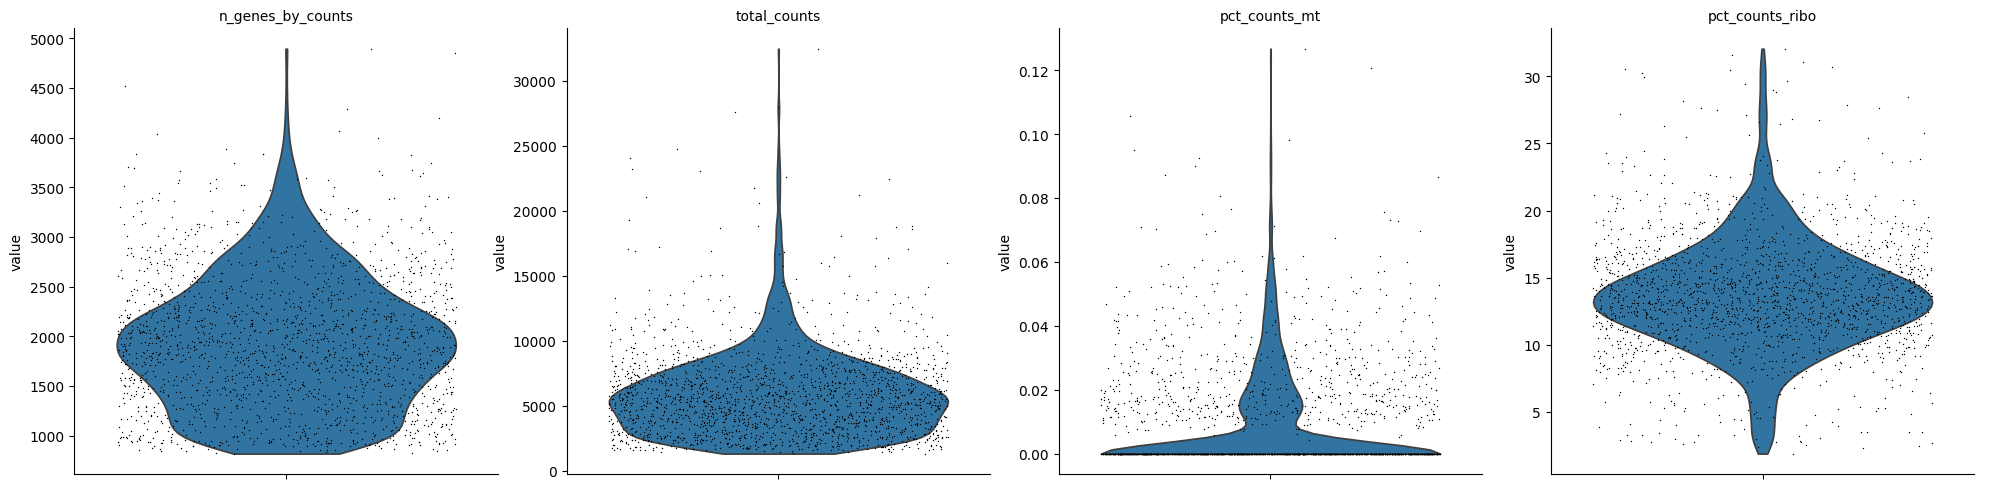

In [21]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'], jitter=0.4, multi_panel=True)

In [22]:
# sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
# sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')
# #instead of picking sunjectively, we can use quanitle
# upper_limit = np.percentile(adata.obs['total_counts'], .98)
# lower_limit = np.percentile(adata.obs['total_counts'], .02)
# print(f'{lower_limit} to {upper_limit}')

In [23]:
# Normalize to 10000 UMI and change to log count
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [24]:
# Select highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Perform PCA
sc.tl.pca(adata, svd_solver='arpack')

# Compute neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# Perform UMAP
sc.tl.umap(adata)

<ipython-input-25-48b57a3c3a89>:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


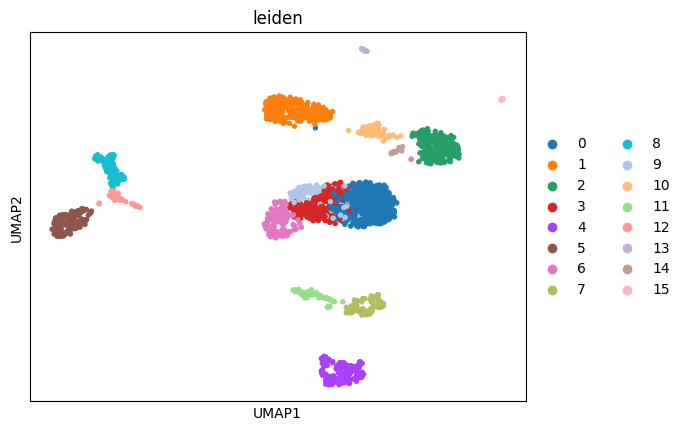

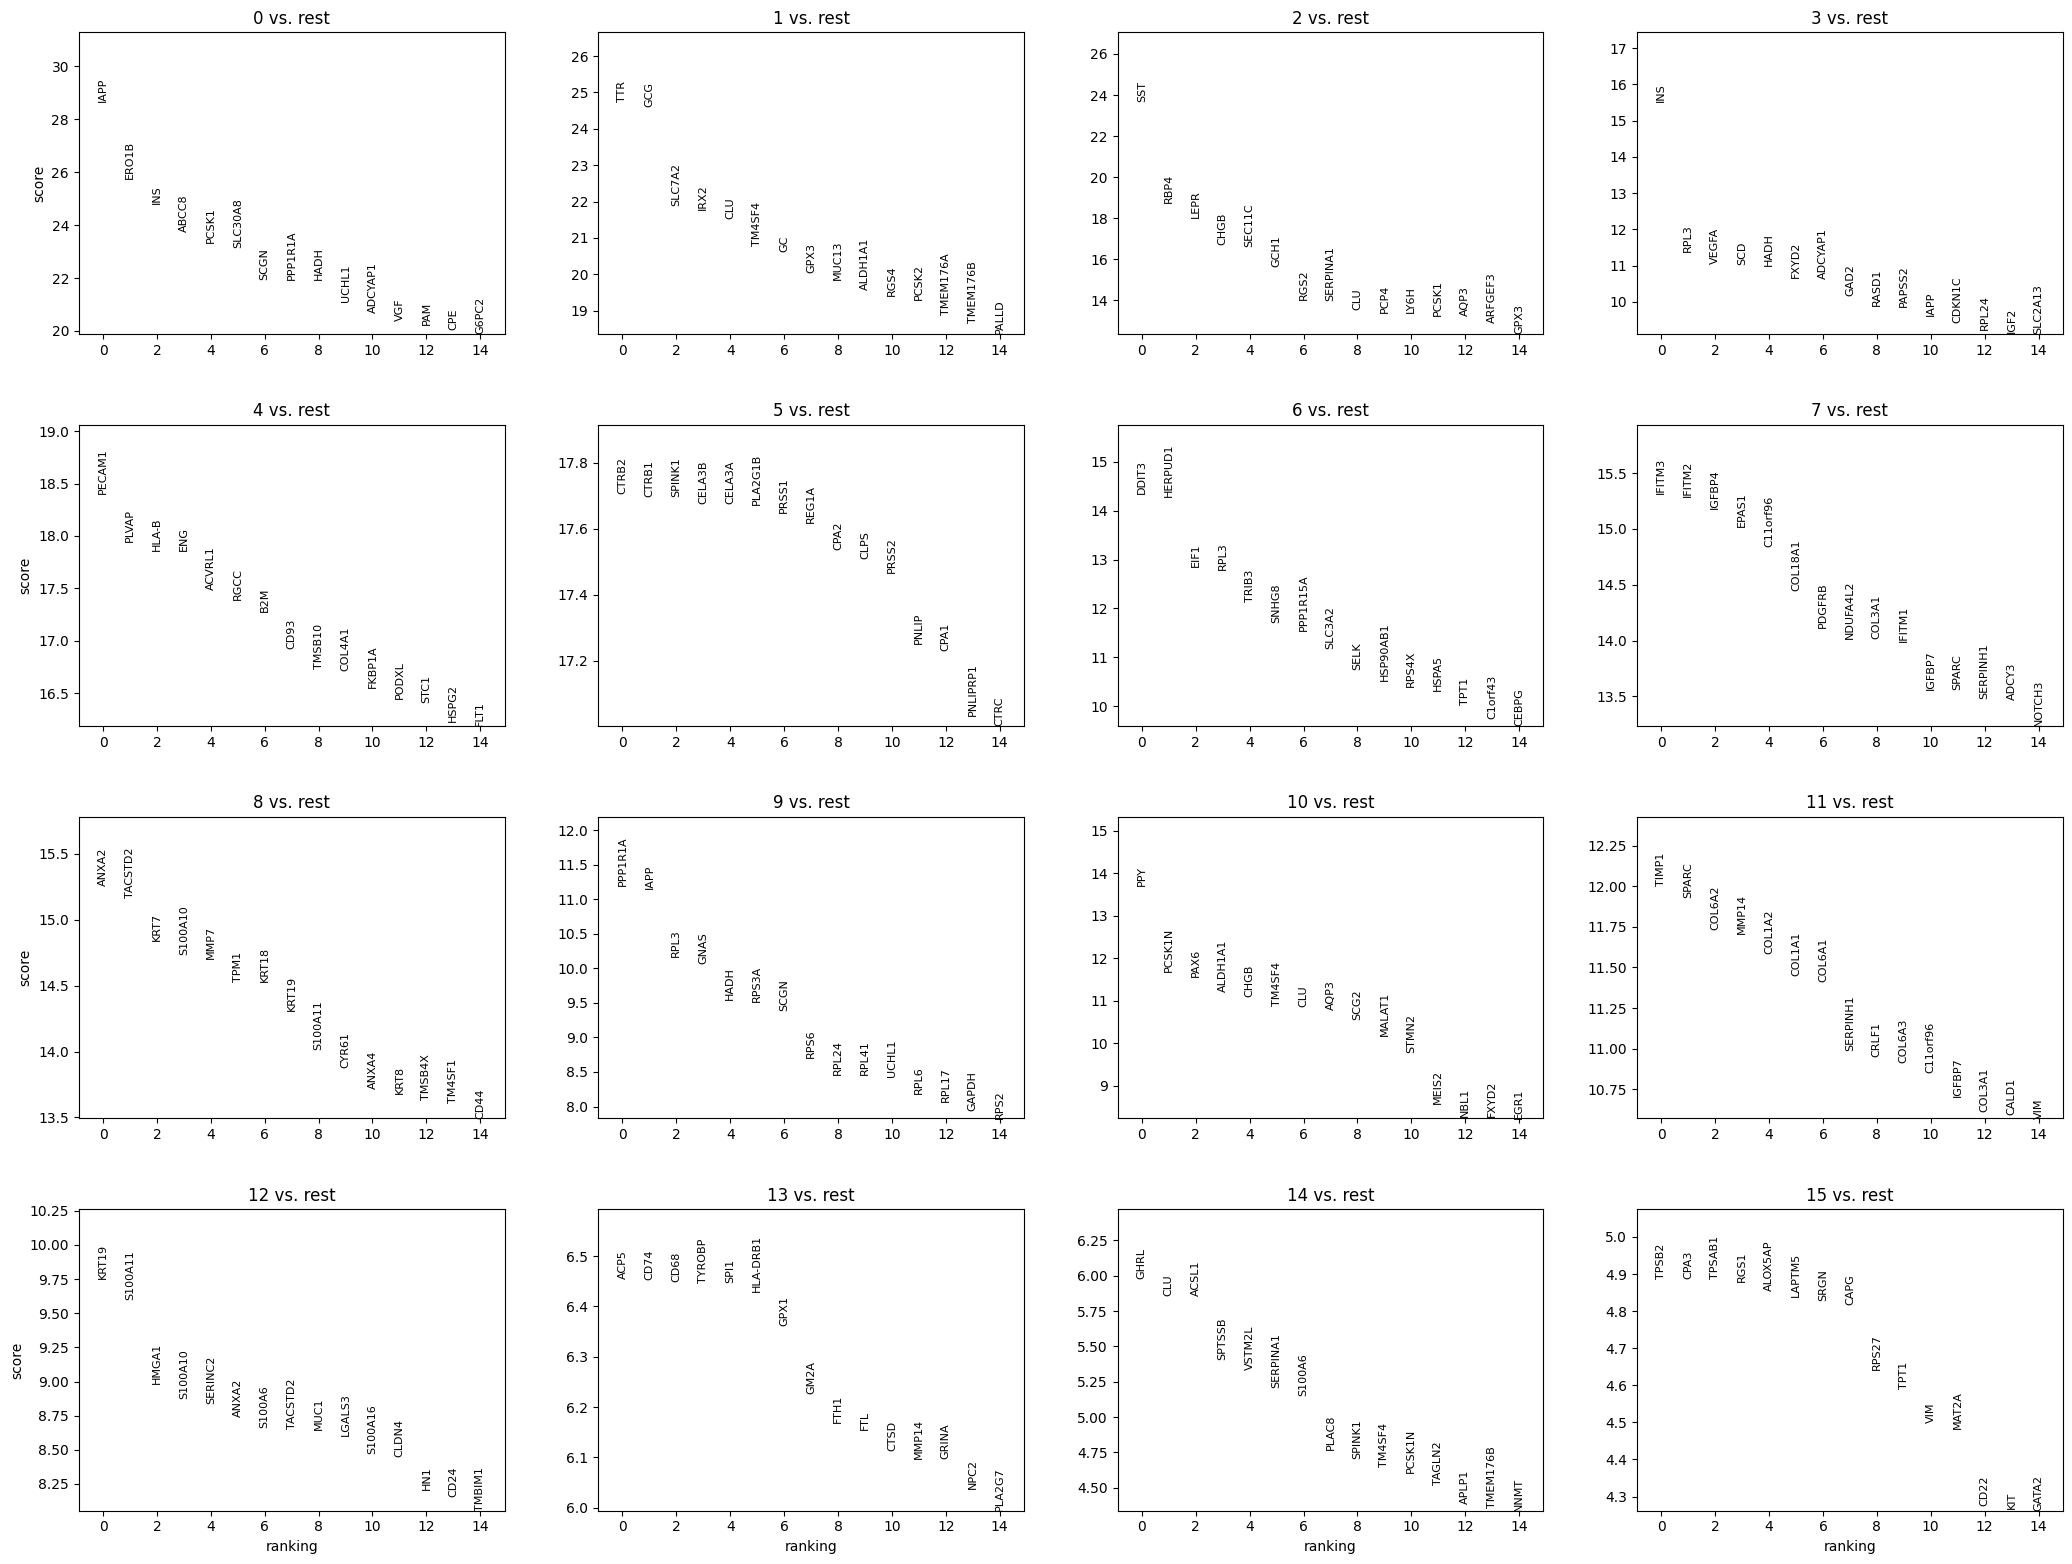

In [25]:
# Perform clustering
sc.tl.leiden(adata)

# Visualize UMAP plot
sc.pl.umap(adata, color=['leiden'], save='umap_clusters.png')

# Find marker genes
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=15, sharey=False, save='marker_genes.png')

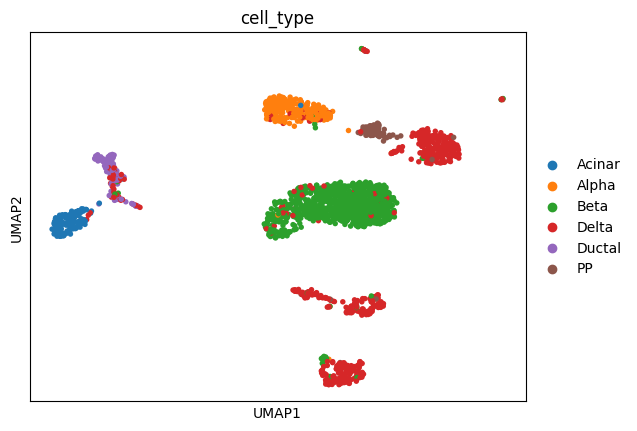

In [26]:
# Define known marker genes for pancreatic cell types
cell_type_markers = {
    'Alpha': ['GCG', 'IRX2', 'ARX'],
    'Beta': ['INS', 'MAFA', 'PDX1'],
    'Delta': ['SST', 'HHEX'],
    'PP': ['PPY', 'MEIS1'],
    'Ductal': ['KRT19', 'SPP1'],
    'Acinar': ['CPA1', 'PRSS1']
}

# Function to annotate cell types based on marker gene expression
def annotate_cell_types(adata, markers):
    cell_types = []
    for cell in adata.obs_names:
        cell_exp = adata[cell, :].X.toarray().flatten()
        max_score = 0
        cell_type = 'Unknown'
        for ct, genes in markers.items():
            score = np.mean([cell_exp[adata.var_names.get_loc(g)] for g in genes if g in adata.var_names])
            if score > max_score:
                max_score = score
                cell_type = ct
        cell_types.append(cell_type)
    return cell_types

adata.obs['cell_type'] = annotate_cell_types(adata, cell_type_markers)

# Visualize annotated cell types
sc.pl.umap(adata, color='cell_type', save='umap_cell_types.png')


In [27]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

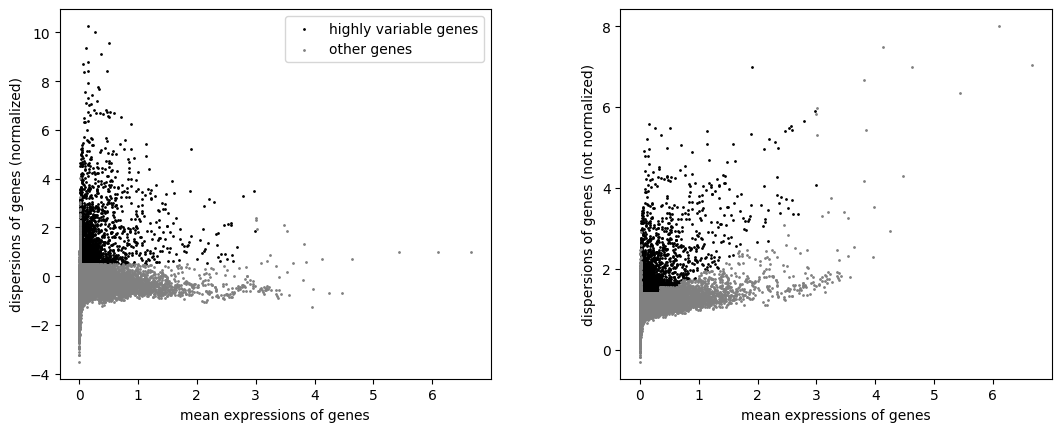

In [28]:
sc.pl.highly_variable_genes(adata)

In [29]:
adata.raw = adata

In [30]:
adata = adata[:, adata.var.highly_variable]

In [31]:
adata

View of AnnData object with n_obs × n_vars = 1937 × 2351
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'leiden', 'cell_type'
    var: 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [32]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_simple.py:657: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [33]:
sc.pp.scale(adata, max_value=10)

In [34]:
sc.tl.pca(adata, svd_solver='arpack')

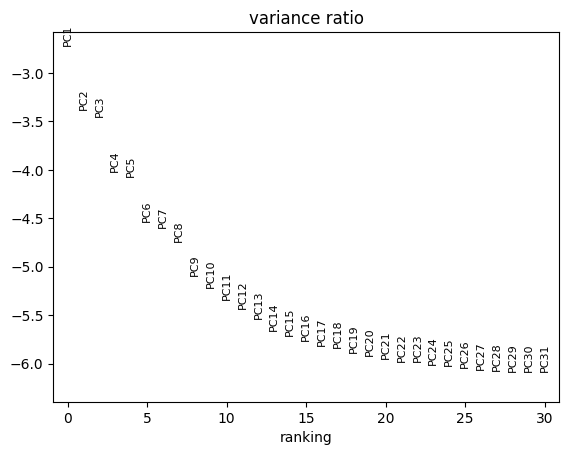

In [35]:
sc.pl.pca_variance_ratio(adata, log=True)

In [36]:
# here it actually showing how the PC are actually contributing to the variance and decide how many PC's to use pick when they start to flatten out

In [37]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)

In [38]:
sc.tl.umap(adata)

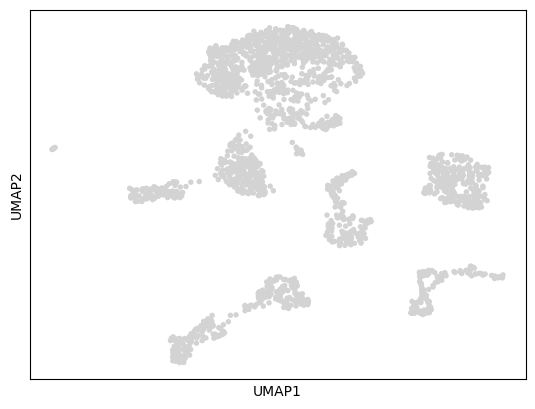

In [39]:
sc.pl.umap(adata)

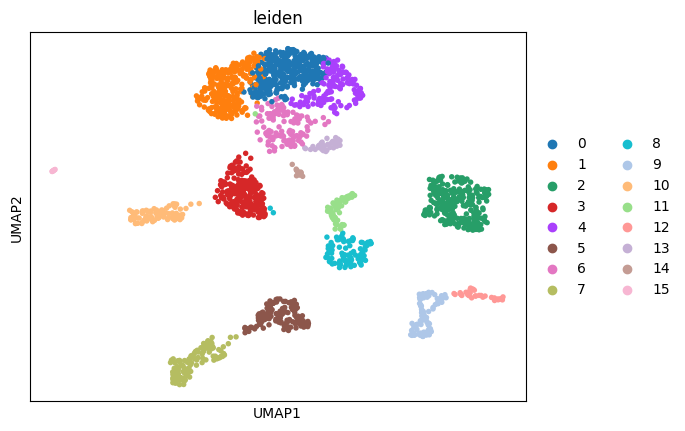

In [40]:
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['leiden'])

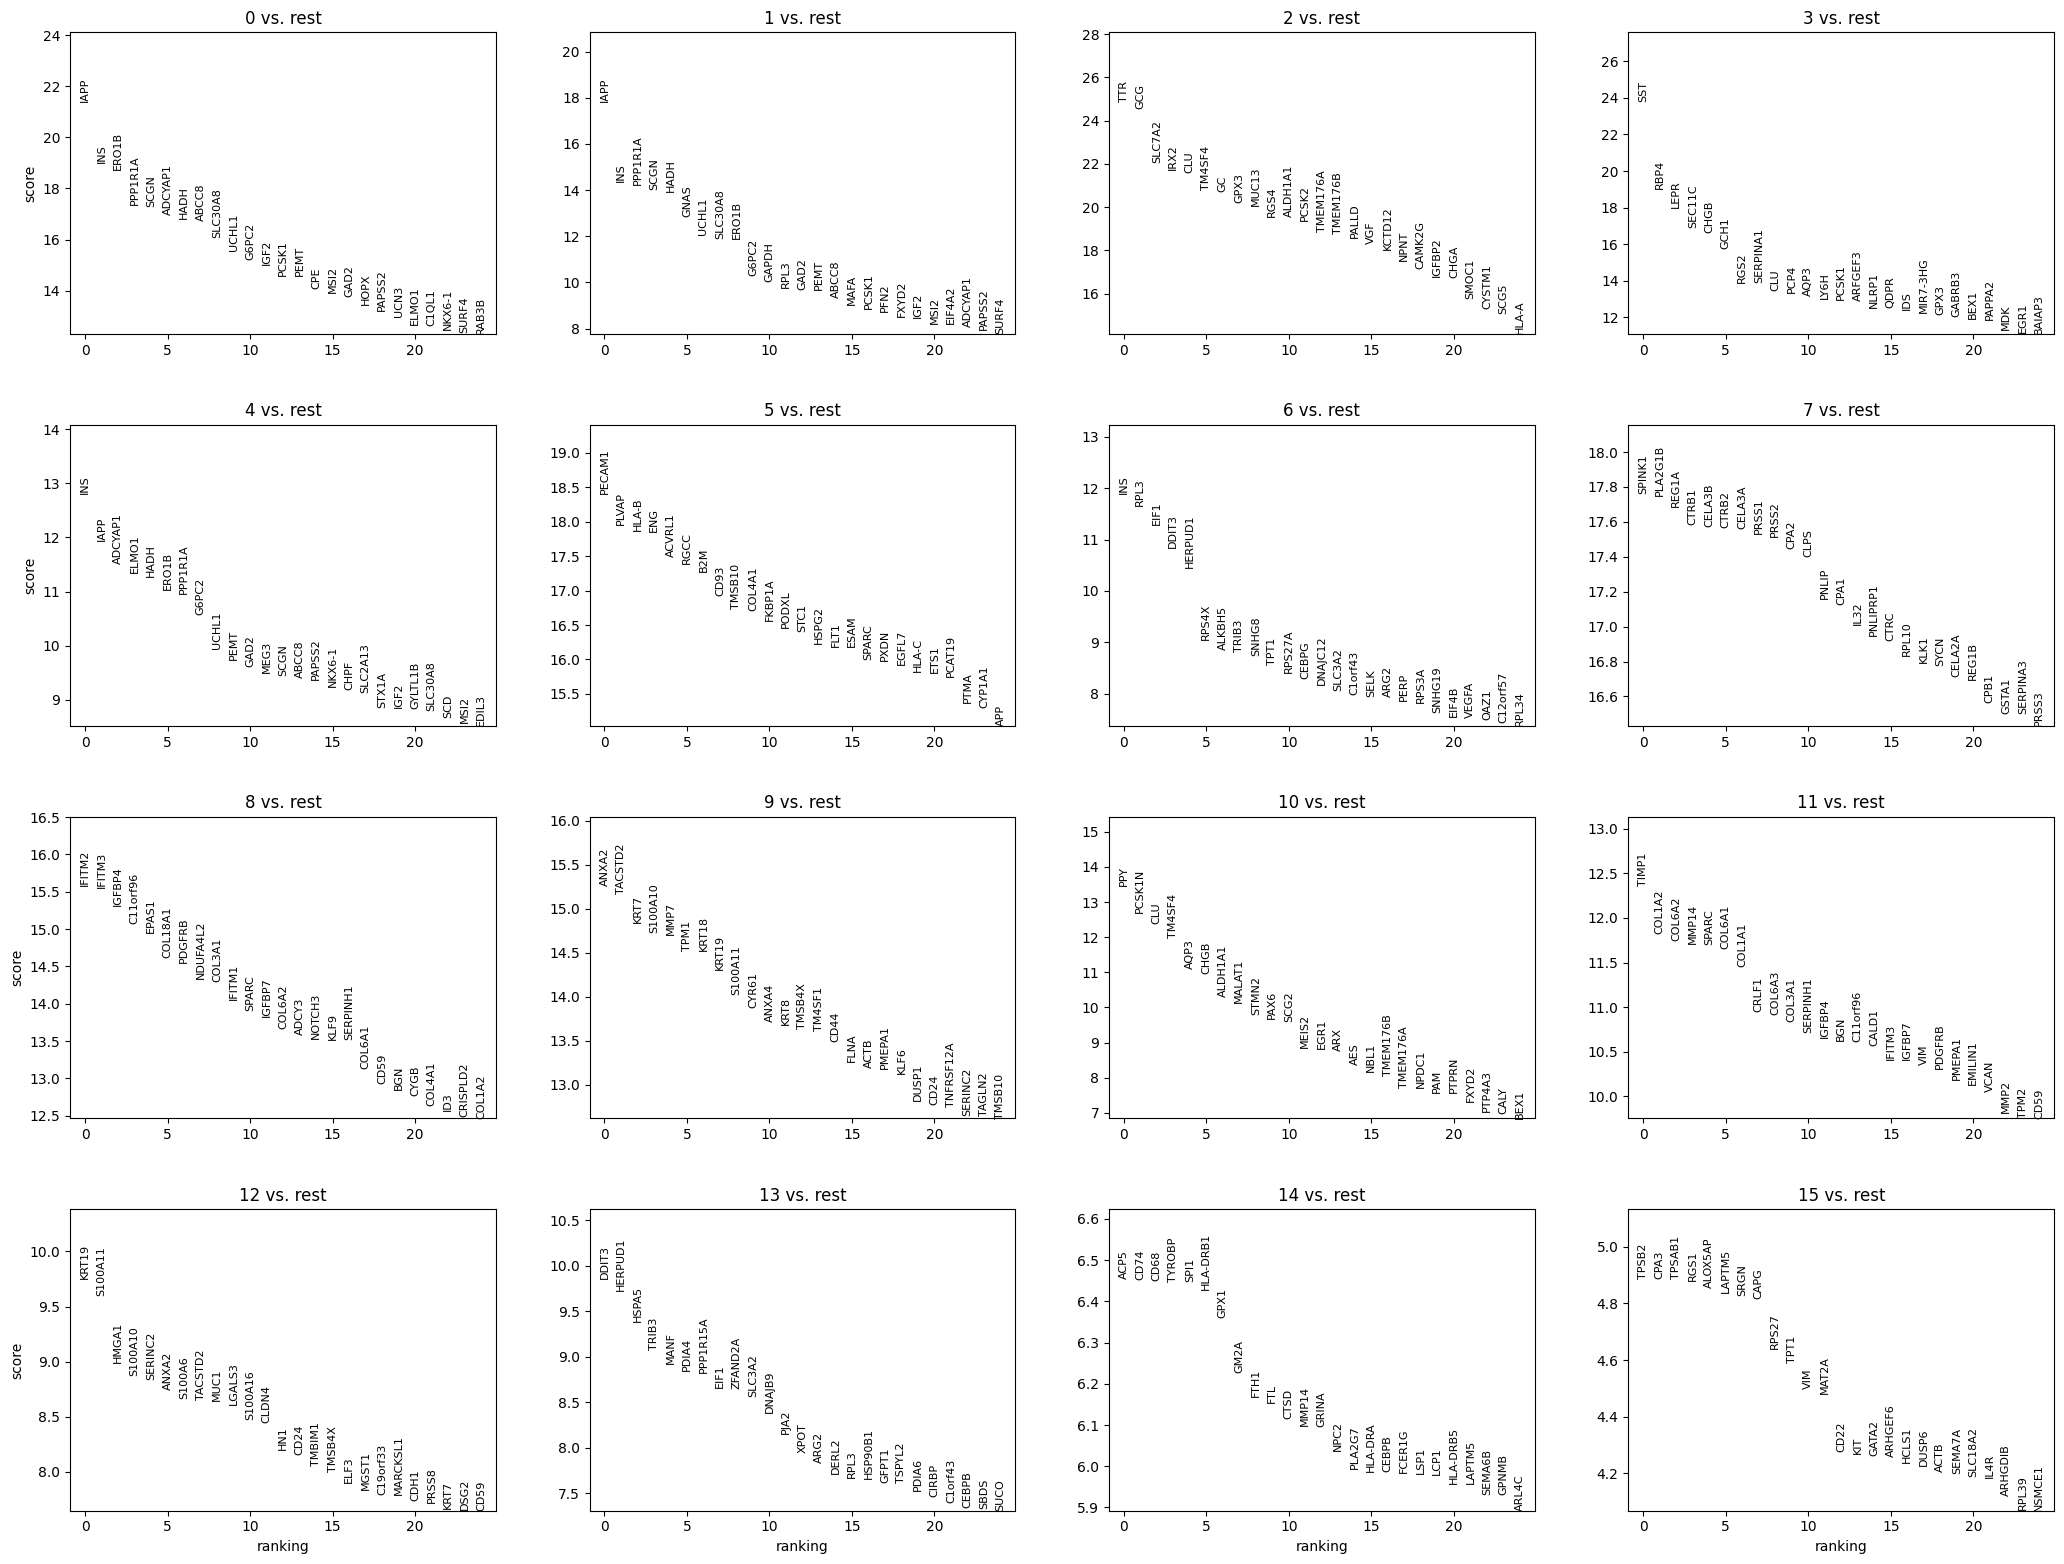

In [41]:
# Find markers
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

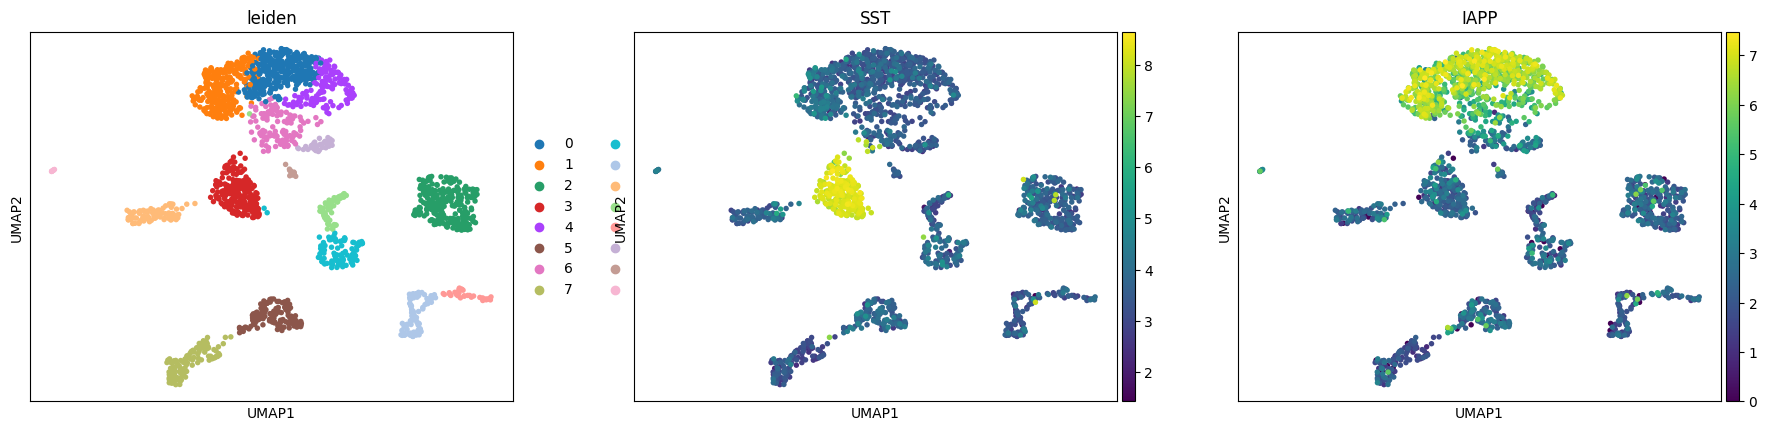

In [42]:
sc.pl.umap(adata, color=['leiden', 'SST', 'IAPP'])